In [4]:
!pwd

/home/pczapla/workspace/ulmfit-multilingual/experiments


In [5]:
from fastai.text import *

In [6]:
# unzip task6_test.zip
# unzip task_6-1.zip -d Task6/task\ 01
# unzip task_6-2.zip -d Task6/task\ 02
# mv Task6/task\ 01 task-1
# mv Task6/task\ 02 task-2
# rmdir Task6

In [7]:
dataset=Path('../data')/'poleval19'/'task-1'
dataset.ls()

[PosixPath('../data/poleval19/task-1/test_set_clean_only_text.txt'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.tmp.tok'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.txt'),
 PosixPath('../data/poleval19/task-1/test_set_clean_only_text.tmp.bpe'),
 PosixPath('../data/poleval19/task-1/test_set_clean_only_text.tmp.enc'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_tags.txt'),
 PosixPath('../data/poleval19/task-1/models'),
 PosixPath('../data/poleval19/task-1/evaulate1.pl'),
 PosixPath('../data/poleval19/task-1/test_set_clean_only_text.tmp.tok'),
 PosixPath('../data/poleval19/task-1/test_set_clean_only_tags.txt'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.tmp.enc'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.tmp.bpe')]

In [8]:
LASER = os.environ.get('LASER', "/home/pczapla/workspace/_oss/LASER")
os.environ['LASER'] = LASER
def cond_add_pypath(*paths):
    for path in paths:
        if path not in sys.path:
            sys.path.append(path)
cond_add_pypath(LASER + '/source',LASER + '/source/tools')

from embed import SentenceEncoder, EncodeLoad, EncodeFile
from text_processing import Token, BPEfastApply, SplitLines, JoinEmbed

In [265]:
from subprocess import run, check_output, DEVNULL
def tokenize(inp_fname, out_fname, lang='en',
          lower_case=True, romanize=False, descape=False,
          verbose=False, over_write=False, gzip=False):
    FASTBPE = LASER + '/tools-external/fastBPE/fast'
    MOSES_BDIR = LASER + '/tools-external/moses-tokenizer/tokenizer/'
    MOSES_TOKENIZER = MOSES_BDIR + 'tokenizer.perl -q -no-escape -threads 20 -l '
    MOSES_LC = MOSES_BDIR + 'lowercase.perl'
    NORM_PUNC = MOSES_BDIR + 'normalize-punctuation.perl -l '
    DESCAPE = MOSES_BDIR + 'deescape-special-chars.perl'
    REM_NON_PRINT_CHAR = MOSES_BDIR + 'remove-non-printing-char.perl'

    # Romanization (Greek only)
    ROMAN_LC = 'python3 ' + LASER + '/source/lib/romanize_lc.py -l '

    # Mecab tokenizer for Japanese
    MECAB = LASER + '/tools-external/mecab'
    assert lower_case, 'lower case is needed by all the models'
    if not out_fname.exists():
        cat = 'zcat ' if gzip else 'cat '
        roman = lang if romanize else 'none'
        # handle some iso3 langauge codes
        if lang in ('cmn', 'wuu', 'yue'):
            lang = 'zh'
        if lang in ('jpn'):
            lang = 'ja'
        if verbose:
            print(' - Tokenizer: {} in language {} {} {}'
                  .format(os.path.basename(inp_fname), lang,
                          '(gzip)' if gzip else '',
                          '(de-escaped)' if descape else '',
                          '(romanized)' if romanize else ''))
        cmd = (cat + str(inp_fname)
            + '|' + REM_NON_PRINT_CHAR
            + '| sed "s/\(@anonymized_account *\)/account /gi"'
#            + '| iconv -f UTF-8 -t ASCII//TRANSLIT '
            + '|' + NORM_PUNC + lang
            + ('|' + DESCAPE if descape else '')
            + '|' + MOSES_TOKENIZER + lang
            + ('| python3 -m jieba -d ' if lang == 'zh' else '')
            + ('|' + MECAB + '/bin/mecab -O wakati -b 50000 ' if lang == 'ja' else '')
            + ('|' + ROMAN_LC + roman if romanize else '')
            + ('| tr "[:upper:]" "[:lower:]"' if lower_case else '')
            + '>' + str(out_fname))
        print ("Tokenziation CMD: ", cmd)
        run(cmd,
            env=dict(os.environ, LD_LIBRARY_PATH=MECAB + '/lib'),
            shell=True)
    elif not over_write and verbose:
        print(' - Tokenizer: {} exists already'
              .format(os.path.basename(out_fname), lang))


def split_lines(*args): return SplitLines(*list(map(str,args)))
def bpe_fast_apply(*args, **kwargs): return BPEfastApply(*list(map(str,args)), **kwargs)
def encode_file(enc, *args, **kwargs): return EncodeFile(enc, *list(map(str,args)), **kwargs)
def join_embed(*args): return JoinEmbed(*list(map(str,args)))
                      
def process_file(inputfn, lang='pl'):
    inputfn = Path(inputfn)
    args = SimpleNamespace(
        encoder=str(Path(LASER)/"models"/"bilstm.93langs.2018-12-26.pt"), 
        bpe_codes=str(Path(LASER)/"models"/"93langs.fcodes"),
        lang=lang,
        buffer_size=10000,
        max_tokens=12000,
        max_sentences=None,
        cpu=False,
        verbose=False,
        stable=True)
    enc = EncodeLoad(args)
    def fn(suffix):
        return inputfn.with_suffix(f'.tmp{suffix}')
    tokenize(inputfn,
          fn('.tok'),
          lang=lang,
          romanize=(True if lang == 'el' else False),
          lower_case=True, gzip=False,
          verbose=args.verbose, over_write=False)
    bpe_fast_apply(fn('.tok'),
             fn('.bpe'),
             args.bpe_codes,
             verbose=args.verbose, over_write=False)
    split_lines(fn('.bpe'),
               fn('.split'),
               fn('.sid'))
#     encode_file(enc,
#                fn('.bpe'),
#                fn('.enc'),
#                verbose=args.verbose, over_write=False,
#                buffer_size=args.buffer_size)
    encode_file(enc,
               fn('.split.bpe'),
               fn('.split.enc'),
               verbose=args.verbose, over_write=False,
               buffer_size=args.buffer_size)

    join_embed(fn('.split.enc'),
              fn('.sid'),
              fn('.enc'))
    return fn('.enc')

In [266]:
!rm {dataset}/training_set_clean_only_text.tmp.*
trn_fn = process_file(dataset / 'training_set_clean_only_text.txt')

 - loading encoder /home/pczapla/workspace/_oss/LASER/models/bilstm.93langs.2018-12-26.pt
Tokenziation CMD:  cat ../data/poleval19/task-1/training_set_clean_only_text.txt|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/remove-non-printing-char.perl| sed "s/\(@anonymized_account *\)/account /gi"|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/normalize-punctuation.perl -l pl|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/tokenizer.perl -q -no-escape -threads 20 -l pl| tr "[:upper:]" "[:lower:]">../data/poleval19/task-1/training_set_clean_only_text.tmp.tok


In [267]:
! cat ../data/poleval19/task-1/training_set_clean_only_text.txt| sed 's/\(@anonymized_account *\)/account /gi' |head











sed: couldn't write 130 items to stdout: Broken pipe
cat: write error: Broken pipe


In [268]:
! cat ../data/poleval19/task-1/training_set_clean_only_text.txt| iconv -f UTF-8 -t ASCII//TRANSLIT |head











iconv: conversion stopped due to problem in writing the output


In [269]:
! head ../data/poleval19/task-1/training_set_clean_only_text.tmp.tok

dla mnie faworytem do tytułu będzie cracovia . zobaczymy , czy typ się sprawdzi .
account account brawo ty daria kibic ma być na dobre i złe
account account super , polski premier składa kwiaty na grobach kolaborantów . ale doczekaliśmy czasów .
account account musi . innej drogi nie mamy .
odrzut natychmiastowy , kwaśna mina , mam problem
jaki on był fajny xdd pamiętam , że spóźniłam się na jego pierwsze zajęcia i to sporo i za karę kazał mi usiąść w pierwszej ławce xd
account no nie ma u nas szczęścia 😉
account dawno kogoś tak wrednego nie widziałam xd
account account zaległości były , ale ważne czy były wezwania do zapłaty z których się klub nie wywiązał .
account account account gdzie jest account . brudziński jesteś kłamcą i marnym kutasem account


In [270]:
!rm {dataset}/test_set_clean_only_text.tmp.*
tst_fn = process_file(dataset / 'test_set_clean_only_text.txt')

 - loading encoder /home/pczapla/workspace/_oss/LASER/models/bilstm.93langs.2018-12-26.pt
Tokenziation CMD:  cat ../data/poleval19/task-1/test_set_clean_only_text.txt|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/remove-non-printing-char.perl| sed "s/\(@anonymized_account *\)/account /gi"|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/normalize-punctuation.perl -l pl|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/tokenizer.perl -q -no-escape -threads 20 -l pl| tr "[:upper:]" "[:lower:]">../data/poleval19/task-1/test_set_clean_only_text.tmp.tok


In [271]:
dim=1024
def read_enc(fn):
    em = np.fromfile(str(fn),dtype=np.float32).reshape(-1, dim)
    return em
read_enc(trn_fn).shape

(10041, 1024)

In [272]:
np.loadtxt(str(dataset/'test_set_clean_only_text.txt'), delimiter='\n', comments=None, dtype=np.str).shape

(1000,)

In [273]:
!wc -l {dataset}/'test_set_clean_only_text.tmp'.*

   1000 ../data/poleval19/task-1/test_set_clean_only_text.tmp.bpe
  13257 ../data/poleval19/task-1/test_set_clean_only_text.tmp.enc
   1000 ../data/poleval19/task-1/test_set_clean_only_text.tmp.tok
  15257 total


In [274]:
!grep "!" ../data/poleval19/task-1/test_set_clean_only_text.tmp.bpe

account account i dzięki temu mamy dziś ces@@ ar@@ zo@@ wą .. 😁 😁 😁 . gor@@ ą@@ co pozdra@@ wi@@ am ! 😁 😁 😁
account account account w na@@ gro@@ de wy@@ pi@@ j mój sy@@ ro@@ p ! : d
account droga p.@@ kam@@ il@@ ko ! le@@ czyć się . le@@ czyć pó@@ ki czas 😁 😁
account pó@@ ł@@ gł@@ ó@@ we@@ k wi@@ eli@@ ń@@ ski , wy@@ myś@@ li@@ ł sobie pó@@ ł@@ autor@@ y@@ tary@@ z@@ m !
rt account account pó@@ ł@@ gł@@ ó@@ we@@ k wi@@ eli@@ ń@@ ski , wy@@ myś@@ li@@ ł sobie pó@@ ł@@ autor@@ y@@ tary@@ z@@ m !
account account na szczę@@ ście account i jego parti@@ a zni@@ kn@@ ą w@@ kró@@ t@@ ce \ n@@ ze scen@@ y politycz@@ nej . bra@@ wo !
fa@@ v albo rt to zrobi@@ ę wam in@@ dy ! ! ! nie wiem czy wszystkim , z@@ ale@@ ży ko@@ go będę ko@@ jar@@ zyć 🔥 🔥 🔥
account account account to był kar@@ ny ? ! oczywi@@ sty kar@@ ny ? ! ha@@ ha od@@ sta@@ w to co bier@@ z@@ esz
account account account masz teraz sz@@ anse na@@ pra@@ wić ten b@@ łą@@ d ! : )
account account account w ta@@ kim razie zdro@@ wia ży@@ 

In [275]:
tst_df = pd.DataFrame({
    'y':np.loadtxt(str(dataset/'test_set_clean_only_tags.txt'),delimiter='\n', comments=None, dtype=np.int),
    'em':list(read_enc(tst_fn)), 
    'txt':np.loadtxt(str(dataset/'test_set_clean_only_text.tmp.bpe'), delimiter='\n', comments=None, dtype=np.str),
})

trn_df = pd.DataFrame({
    'y':np.loadtxt(str(dataset/'training_set_clean_only_tags.txt'),delimiter='\n', comments=None, dtype=np.int),
    'em':list(read_enc(trn_fn)), 
    'txt':np.loadtxt(str(dataset/'training_set_clean_only_text.tmp.bpe'), delimiter='\n', comments=None, dtype=np.str),
})




In [276]:
trn_df.head()

,y,em,txt
0,0,"[0.0020520384, 0.005157103, 0.012943947, 0.024...",dla mnie fa@@ wor@@ y@@ tem do ty@@ tu@@ łu bę...
1,0,"[0.0037102806, -2.0261248e-05, 7.142721e-05, 0...",account account bra@@ wo ty dar@@ ia ki@@ bi@@...
2,0,"[0.011618567, 0.0027558685, 0.00044608297, 0.0...","account account super , pol@@ ski premier sk@@..."
3,0,"[0.034281317, -9.7129705e-05, 0.0016056199, 0....",account account musi . in@@ nej dro@@ gi nie m...
4,0,"[0.007905566, 0.0017290562, -0.0015668176, 0.0...","odr@@ zut nat@@ ych@@ mi@@ a@@ sto@@ wy , kwa@..."


In [277]:
tst_df['em'][0]

array([ 0.015996,  0.002804, -0.004015,  0.018448, ...,  0.022837,  0.005017,  0.011453,  0.016846], dtype=float32)

In [278]:
class EmbeddingText(ItemBase):
    "Basic item for <code>text</code> data in numericalized `ids`."
    def __init__(self, emb, text): self.data,self.text = np.array(emb, dtype=np.float32),text
    def __str__(self):  return str(self.text)

In [279]:
class EmbeddingList(ItemList):
    "Basic `ItemList` for embeding of text data."
    _bunch = DataBunch # TextDataBunch converts input to LongTensor !
    _processor = []

    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)

    def find_text_for_em(self, em):
        # todo find a way to reverse embedding
        return self.inner_df['txt'][1]
        
    def get(self, i):
        o = super().get(i)
        return EmbeddingText(o, self.inner_df['txt'][i])

    def reconstruct(self, t:Tensor):
        return EmbeddingText(t, self.find_text_for_em(t))

    def show_xys(self, xs, ys, max_len:int=70)->None:
        "Show the `xs` (inputs) and `ys` (targets). `max_len` is the maximum number of tokens displayed."
        from IPython.display import display, HTML
        names = ['text','target']
        items = []
        for i, (x,y) in enumerate(zip(xs,ys)):
            txt_x = ' '.join(x.text.split(' ')[:max_len]) if max_len is not None else x.text
            items.append([txt_x, y])
        items = np.array(items)
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False)))

    def show_xyzs(self, xs, ys, zs, max_len:int=70):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions). `max_len` is the maximum number of tokens displayed."
        from IPython.display import display, HTML
        items,names = [],['text','target','prediction']
        for i, (x,y,z) in enumerate(zip(xs,ys,zs)):
            txt_x = ' '.join(x.text.split(' ')[:max_len]) if max_len is not None else x.text
            items.append([txt_x, y, z])
        items = np.array(items)
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False)))

In [280]:
path=dataset/"models"
src = ItemLists(path, 
                EmbeddingList.from_df(trn_df, cols=1, path=path),
                EmbeddingList.from_df(tst_df, cols=1, path=path))
classes=np.unique(trn_df['y'])
src.label_from_lists(trn_df['y'], tst_df['y'], classes=classes, processor=[])
data = src.databunch(bs=200)

In [281]:
data.show_batch()

text,target
account account bra@@ wo ty dar@@ ia ki@@ bi@@ c ma być na dobre i zł@@ e,0
account account bra@@ wo ty dar@@ ia ki@@ bi@@ c ma być na dobre i zł@@ e,0
account account bra@@ wo ty dar@@ ia ki@@ bi@@ c ma być na dobre i zł@@ e,0
account account bra@@ wo ty dar@@ ia ki@@ bi@@ c ma być na dobre i zł@@ e,0
account account bra@@ wo ty dar@@ ia ki@@ bi@@ c ma być na dobre i zł@@ e,0


In [282]:
class LaserSentCLS(nn.Module):
    def __init__(self, idim=1024, odim=2, nhid=None,
                 dropout=0.0, activation='TANH'):
        super().__init__()
        modules = []

        modules = []
        print(' - mlp {:d}'.format(idim), end='')
        if len(nhid) > 0:
            if dropout > 0:
                modules.append(nn.Dropout(p=dropout))
            nprev = idim
            for nh in nhid:
                if nh > 0:
                    modules.append(nn.Linear(nprev, nh))
                    nprev = nh
                    if activation == 'TANH':
                        modules.append(nn.Tanh())
                        print('-{:d}t'.format(nh), end='')
                    elif activation == 'RELU':
                        modules.append(nn.ReLU())
                        print('-{:d}r'.format(nh), end='')
                    else:
                       raise Exception('Unrecognized activation {activation}')
                    if dropout > 0:
                        modules.append(nn.Dropout(p=dropout))
            modules.append(nn.Linear(nprev, odim))
            print('-{:d}, dropout={:.1f}'.format(odim, dropout))
        else:
            modules.append(nn.Linear(idim, odim))
            print(' - mlp %d-%d'.format(idim, odim))
        self.mlp = nn.Sequential(*modules)
    def forward(self, x):
        return self.mlp(x)

In [283]:
data.train_dl.dl.batch_sampler.sampler

In [284]:
data.train_dl.dl.batch_size

200

In [285]:
m=LaserSentCLS(nhid=[10, 8],dropout=0)
learn = Learner(data, m, metrics=[accuracy, FBeta(beta=1, average='binary')])

 - mlp 1024-10t-8t-2, dropout=0.0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


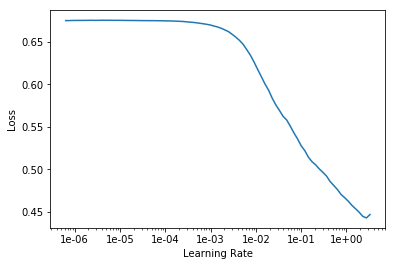

In [286]:
learn.lr_find();learn.recorder.plot()

In [287]:
learn.fit_one_cycle(20, 1e-1)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.333184,0.430970,0.866000,0.000000,00:00
1,0.305062,0.394566,0.866000,0.000000,00:00
2,0.297022,0.397638,0.866000,0.000000,00:00
3,0.294646,0.443322,0.866000,0.000000,00:00
4,0.289282,0.619350,0.866000,0.000000,00:00
5,0.272823,0.386414,0.866000,0.000000,00:00
6,0.243332,0.302898,0.892000,0.504587,00:00
7,0.227738,0.289813,0.880000,0.545455,00:00
8,0.209937,0.298856,0.885000,0.488889,00:00
9,0.200507,0.310476,0.886000,0.525000,00:00


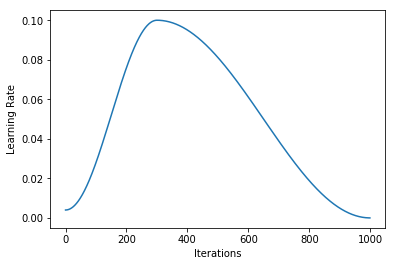

In [288]:
learn.recorder.plot_lr()

In [289]:
interp = ClassificationInterpretation.from_learner(learn)


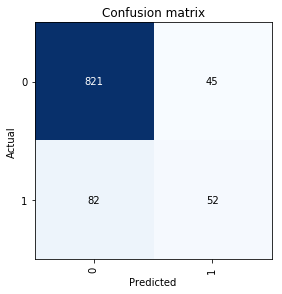

In [290]:
interp.plot_confusion_matrix()

In [291]:
l, i = interp.top_losses()

In [292]:
interp.most_confused()

[(1, 0, 82), (0, 1, 45)]

In [293]:
for ix in range(0,10): print(data.valid_ds[i[ix]])

(EmbeddingText tym których nie było na me@@ cz@@ u ze względu na koniec zgo@@ dy mam kilka sł@@ ów do prze@@ kazan@@ ia@@ .@@ wy@@ pier@@ d@@ ala@@ ć do wro@@ c@@ ła@@ wia albo g@@ da@@ ń@@ ska, Category 1)
(EmbeddingText account account ni@@ est@@ ety nie og@@ lą@@ da@@ łem . ale jedna rzecz w tym po@@ ście jest nie@@ prawdzi@@ wa . Ż@@ al@@ ek i wied@@ za to dwa wy@@ klu@@ cza@@ jące się by@@ ty, Category 1)
(EmbeddingText account lis czy ty jesteś Ż@@ y@@ dem . ? ? ?, Category 1)
(EmbeddingText account za sz@@ czy@@ t ? chyba za sz@@ czy@@ to@@ wanie ...., Category 1)
(EmbeddingText account do@@ kład@@ nie , pis@@ dzi@@ el@@ stwo nie ma prawa roz@@ pier@@ d@@ ala@@ ć systemu , są@@ dow@@ nict@@ wa nie maj@@ ąc większo@@ ści, Category 1)
(EmbeddingText account chciał@@ byś aby tak było mier@@ no@@ to : ), Category 1)
(EmbeddingText account kama , słu@@ ch@@ ej no , gdzie masz bi@@ uro ? chciałbym coś mach@@ n@@ ąć spra@@ jem ., Category 1)
(EmbeddingText rt account account chciał@@ b

In [295]:
neutral_as_offensive = np.nonzero((interp.pred_class != interp.y_true) & (interp.y_true == 0)).reshape(-1)
for ix in neutral_as_offensive: print(data.valid_ds[ix])

(EmbeddingText account wie@@ czna zdra@@ da , nie zdra@@ da , trzeba roz@@ mawi@@ ać , pier@@ dol@@ enie od rzeczy, Category 0)
(EmbeddingText account account to pani kry@@ sia jest two@@ ją oj@@ czy@@ zn@@ ą ?, Category 0)
(EmbeddingText account droga p.@@ kam@@ il@@ ko ! le@@ czyć się . le@@ czyć pó@@ ki czas 😁 😁, Category 0)
(EmbeddingText account du@@ baj w@@ zor@@ em , czy@@ li jednak islam , sal@@ am al@@ ej@@ kum ci@@ em@@ ki@@ e@@ wi@@ cz, Category 0)
(EmbeddingText account a ja za@@ łoż@@ ę fit@@ blo@@ ga 😂 😂 😂, Category 0)
(EmbeddingText account to tak jak ja prze@@ widział@@ em , że cię nie w@@ pusz@@ cza do g@@ b, Category 0)
(EmbeddingText prowad@@ zą@@ cy mówi ze nikt mu nie wy@@ s@@ ła@@ ł sz@@ ki@@ ców projekt@@ ów jak nie jak ja ci wy@@ sł@@ ałam im@@ be@@ cy@@ lu, Category 0)
(EmbeddingText ra@@ fa@@ ł br@@ zo@@ zo@@ w@@ ski ma nar@@ ze@@ cz@@ on@@ ą ? mam na@@ dzie@@ je m , że na co@@ dzień jej aż tak nie fa@@ ł@@ sz@@ uje jak w tym kol@@ e fortun@@ y a jeśli tak to 